### reference following this [paper](https://arxiv.org/abs/1609.02907)

In [ ]:
!git clone https://github.com/tkipf/pygcn.git   

In [19]:
import os
os.chdir("/content/pygcn/pygcn")

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from utils import *

### Layer definition

we define a weight matrix $W$ with dimensions (input_dimension, output_dimension) 

Example if the feature vector of the input layer has D = 10 and i want the output to be D = 15, the matrix will be of shape (10 x 15)

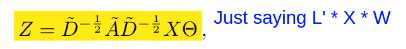

In [23]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()


    
    # This is a function that does Xavier initalization.
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)


    def forward(self, input, adj):
        support = torch.mm(input, self.weight) # matrix multiplication of the input with the weight matrix
        output = torch.spmm(adj, support) # then sparse matrix multiplication with the normalized laplacian matrix as in the paper
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

### Building the model
- The model is simply 2 graph convolutional layers
- After the first grah convolutinal layer we apply a ReLU function to introduce the non-linearity.
- After the second layer we pass it through a softmax function.

In [14]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

### Dataset Description   (Cora dataset)



The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:
		Case_Based
		Genetic_Algorithms
		Neural_Networks
		Probabilistic_Methods
		Reinforcement_Learning
		Rule_Learning
		Theory


THE DIRECTORY CONTAINS TWO FILES:

The .content file contains descriptions of the papers in the following format:

		<paper_id> <word_attributes>+ <class_label>


The .cites file contains the citation graph of the corpus. Each line describes a link in the following format:

		<ID of cited paper> <ID of citing paper>


### Main file

In [ ]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from pygcn.utils import load_data, accuracy
from pygcn.models import GCN


# This is just a parser for optional hyper-parameters
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')                                 # CUDA
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')                      
parser.add_argument('--seed', type=int, default=42, help='Random seed.')            # Random seed
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs to train.')                              # num of epochs
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')                                  # learning rate
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')                   # Decay rate for adam optimization
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')                                 # hidden layer dimension
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()   


# observe
# idx_train = range(140)
# idx_val = range(200, 500)
# idx_test = range(500, 1500)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])   # cross entropy loss
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

In [22]:
!python3 train.py

Loading cora dataset...
Epoch: 0001 loss_train: 1.9342 acc_train: 0.1286 loss_val: 1.9261 acc_val: 0.1567 time: 0.1707s
Epoch: 0002 loss_train: 1.9133 acc_train: 0.2214 loss_val: 1.9156 acc_val: 0.1567 time: 0.0189s
Epoch: 0003 loss_train: 1.9170 acc_train: 0.2143 loss_val: 1.9055 acc_val: 0.1567 time: 0.0186s
Epoch: 0004 loss_train: 1.9008 acc_train: 0.2214 loss_val: 1.8961 acc_val: 0.1600 time: 0.0187s
Epoch: 0005 loss_train: 1.8936 acc_train: 0.2214 loss_val: 1.8868 acc_val: 0.1767 time: 0.0193s
Epoch: 0006 loss_train: 1.8725 acc_train: 0.3571 loss_val: 1.8778 acc_val: 0.3500 time: 0.0187s
Epoch: 0007 loss_train: 1.8775 acc_train: 0.3429 loss_val: 1.8692 acc_val: 0.4433 time: 0.0188s
Epoch: 0008 loss_train: 1.8682 acc_train: 0.3786 loss_val: 1.8610 acc_val: 0.4433 time: 0.0187s
Epoch: 0009 loss_train: 1.8590 acc_train: 0.4000 loss_val: 1.8528 acc_val: 0.3900 time: 0.0183s
Epoch: 0010 loss_train: 1.8485 acc_train: 0.3786 loss_val: 1.8445 acc_val: 0.3633 time: 0.0186s
Epoch: 0011 loss

In [18]:
!ls

data  figure.png  LICENCE  pygcn  README.md  setup.py
